In [2]:
import os
from PIL import Image
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
import keras
from keras.models import Sequential,Input,Model
from keras.layers import Dense, Dropout, Flatten
from keras.layers import Conv2D, MaxPooling2D
from keras.layers.normalization import BatchNormalization
from keras.layers.advanced_activations import LeakyReLU
import scipy.misc
from skimage import transform
import warnings

warnings.filterwarnings("ignore")

### Read the images and generate the train and test dataset

In [10]:
#convertering list of training data paths to df
train_dir = './train/'
# print(train_dir)
train_list = os.listdir(train_dir)


In [13]:
len(train_list)

12

In [15]:
# Put train data into dataframe
records = []
for category in train_list:
    img_list = os.listdir(train_dir + category)
    for img in img_list:
        records.append((img,category))
        
df_train = pd.DataFrame.from_records(records,columns=['image','category'])

print(df_train.head())

           image     category
0  0050f38b3.png  Black-grass
1  0183fdf68.png  Black-grass
2  0260cffa8.png  Black-grass
3  05eedce4d.png  Black-grass
4  075d004bc.png  Black-grass


In [19]:
#looking at the test data
test_dir = './test'
test_list = os.listdir(test_dir)
print('Train Data', len(df_train.index))
print('Test Data',type(test_list),len(test_list))
print('categories',os.listdir(train_dir))
print('# of categories', len(os.listdir(train_dir)))


Train Data 4750
Test Data <class 'list'> 794
categories ['Black-grass', 'Charlock', 'Cleavers', 'Common Chickweed', 'Common wheat', 'Fat Hen', 'Loose Silky-bent', 'Maize', 'Scentless Mayweed', 'Shepherds Purse', 'Small-flowered Cranesbill', 'Sugar beet']
# of categories 12


W1006 18:56:36.871271 16212 image.py:700] Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


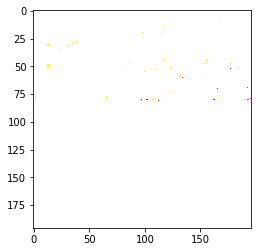

In [22]:
for i in list(df_train['image'])[0:1]:
    img = Image.open(train_dir + df_train['category'][0] + '/' + i)
    img.load()
    data = np.asarray(img, dtype="float32" )
    plt.imshow(data)
    plt.show()

In [25]:
dim_image = []
for i in (train_dir + df_train['category'] + '/' + df_train['image']):
    img = Image.open(i)
    data = img.size
    dim_image.append(data[0])
print('smallest image dimension', min(dim_image))

i_height = min(dim_image)
i_width = min(dim_image)

X = []
count = 0
bad_images = []
#df_train = df_train.drop(df_train.index[bad_images])
for i in (train_dir + df_train['category'] + '/' + df_train['image']):
    img = Image.open(i)
    img.load()
    img = np.asarray(img, dtype='float32')
    img = img/255
    data = transform.resize(img,(49,49))
    if data.size != 7203:
        bad_images.append(count)
#     plt.imshow(data)
#     plt.show()
#     X.append(data)
    count += 1
print('bad images',bad_images)

df_train = df_train.drop(df_train.index[bad_images])
for i in (train_dir + df_train['category'] + '/' + df_train['image']):
    img = Image.open(i)
    img.load()
    img = np.asarray(img, dtype='float32')
    img = img/255
    data = transform.resize(img,(49,49))
    X.append(data)

X = np.array(X)

y = np.array(df_train['category'].astype('category').cat.codes)

print('Done creating X and y.')
print('X Shape',X.shape)

smallest image dimension 49
bad images []
Done creating X and y.
X Shape (4726, 49, 49, 3)


### Divide the data set into Train and validation data sets

In [24]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

im_shape = (49,49,3)
batch_size = 10

cnn  = Sequential([
    Conv2D(32, kernel_size=(3,3), activation='linear', input_shape=im_shape, padding='same'),
    LeakyReLU(alpha=0.1),
    MaxPooling2D((2,2), padding='same'),
    Conv2D(64, kernel_size=(3,3), activation='linear', padding='same'),
    LeakyReLU(alpha=0.1),
    MaxPooling2D((2,2), padding='same'),
    Conv2D(128, kernel_size=(3,3), activation='linear', padding='same'),
    LeakyReLU(alpha=0.1),
    MaxPooling2D((2,2), padding='same'),
    Flatten(),
    Dense(50,activation='relu'),
    Dense(12, activation='softmax')
])

cnn.compile(loss='sparse_categorical_crossentropy', optimizer=keras.optimizers.Adam(lr=0.001), metrics=['accuracy'])

cnn. fit(X_train, y_train, batch_size=batch_size, epochs=10, verbose=1, validation_data=(X_test,y_test))

W1006 21:43:50.730728 16212 deprecation_wrapper.py:119] From C:\Users\obuli\.conda\envs\py36\lib\site-packages\keras\backend\tensorflow_backend.py:74: The name tf.get_default_graph is deprecated. Please use tf.compat.v1.get_default_graph instead.

W1006 21:43:50.832153 16212 deprecation_wrapper.py:119] From C:\Users\obuli\.conda\envs\py36\lib\site-packages\keras\backend\tensorflow_backend.py:517: The name tf.placeholder is deprecated. Please use tf.compat.v1.placeholder instead.

W1006 21:43:50.866895 16212 deprecation_wrapper.py:119] From C:\Users\obuli\.conda\envs\py36\lib\site-packages\keras\backend\tensorflow_backend.py:4138: The name tf.random_uniform is deprecated. Please use tf.random.uniform instead.

W1006 21:43:50.952360 16212 deprecation_wrapper.py:119] From C:\Users\obuli\.conda\envs\py36\lib\site-packages\keras\backend\tensorflow_backend.py:3976: The name tf.nn.max_pool is deprecated. Please use tf.nn.max_pool2d instead.

W1006 21:43:51.216421 16212 deprecation_wrapper.py:

Train on 3780 samples, validate on 946 samples
Epoch 1/10
3780/3780 [==============================] - 34s 9ms/step - loss: 2.0828 - acc: 0.2704 - val_loss: 1.5633 - val_acc: 0.4863
Epoch 2/10
3780/3780 [==============================] - 7s 2ms/step - loss: 1.2821 - acc: 0.5632 - val_loss: 1.0315 - val_acc: 0.6533
Epoch 3/10
3780/3780 [==============================] - 7s 2ms/step - loss: 0.9043 - acc: 0.6981 - val_loss: 0.9352 - val_acc: 0.6860
Epoch 4/10
3780/3780 [==============================] - 7s 2ms/step - loss: 0.7291 - acc: 0.7585 - val_loss: 0.8198 - val_acc: 0.7178
Epoch 5/10
3780/3780 [==============================] - 7s 2ms/step - loss: 0.5973 - acc: 0.7987 - val_loss: 0.7121 - val_acc: 0.7579
Epoch 6/10
3780/3780 [==============================] - 7s 2ms/step - loss: 0.4578 - acc: 0.8489 - val_loss: 0.8360 - val_acc: 0.7336
Epoch 7/10
3780/3780 [==============================] - 7s 2ms/step - loss: 0.3881 - acc: 0.8653 - val_loss: 0.8715 - val_acc: 0.7114
Epoch 8/10
378